In [1]:
import os
import sys
import hashlib
import zipfile
import json
import csv
import numpy as np
import re
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import scipy
import networkx as nx
import spacy

try:
    import requests
except ImportError:
    print((
        "The requests module is required to download data --\n"
        "please install it with pip install requests."
    ))
    sys.exit(1)

In [2]:
# download functions is ADAPTED FROM

# download
# Downloads the example datasets for running the examples.
#
# Author:   Rebecca Bilbro <rbilbro@districtdatalabs.com>
# Author:   Benjamin Bengfort <bbengfort@districtdatalabs.com>
# Author:   Raul Peralta <raulpl25@gmail.com>
# Created:  Wed May 18 11:54:45 2016 -0400
#
# Copyright (C) 2016 District Data Labs
# For license information, see LICENSE.txt
#
# ID: download.py [1f73d2b] benjamin@bengfort.com $

"""
Downloads the example datasets for running the examples.
"""

'\nDownloads the example datasets for running the examples.\n'

In [3]:
##########################################################################
## Links and MD5 hash of datasets
##########################################################################

DATASETS = {
    'hobbies': {
        'url': 'https://s3.amazonaws.com/ddl-data-lake/yellowbrick/hobbies.zip',
        'signature': '415c8f68df1486d5d84a1d1757a5aa3035aef5ad63ede5013c261d622fbd29d8'}
}


##########################################################################
## Download functions
##########################################################################

def sha256sum(path, blocksize=65536):
    """
    Computes the SHA256 signature of a file to verify that the file has not
    been modified in transit and that it is the correct version of the data.
    """
    sig = hashlib.sha256()
    with open(path, 'rb') as f:
        buf = f.read(blocksize)
        while len(buf) > 0:
            sig.update(buf)
            buf = f.read(blocksize)
    return sig.hexdigest()


def download_data(url, path='data', signature=None, extract=True):
    """
    Downloads the zipped data set specified at the given URL, saving it to
    the output path specified. This function verifies the download with the
    given signature (if supplied) and extracts the zip file if requested.
    """
    # Create the output directory if it does not exist
    if not os.path.exists(path):
        os.mkdir(path)

    # Get the name of the file from the URL
    name = os.path.basename(url)
    dlpath = os.path.join(path, name)

    # Fetch the response in a streaming fashion and write it to disk.
    response = requests.get(url, stream=True)
    with open(dlpath, 'wb') as f:
        for chunk in response.iter_content(65536):
            f.write(chunk)

    # If verify, compare the signature
    if signature is not None:
        dlsignature = sha256sum(dlpath)
        if signature != dlsignature:
            raise ValueError(
                "Download signature does not match hardcoded signature!"
            )

    # If extract, extract the zipfile.
    if extract:
        zf = zipfile.ZipFile(dlpath)
        zf.extractall(path)


def download_all(path='data', verify=True, extract=True):
    """
    Downloads all the example datasets. If verify is True then compare the
    download signature with the hardcoded signature. If extract is True then
    extract the contents of the zipfile to the given path.
    """
    for name, meta in DATASETS.items():
        url = meta['url']
        signature = meta['signature'] if verify else None

        download_data(url, path=path, signature=signature, extract=extract)


def _load_file_data(name, path='data', extract=True):
    """
    Returns the information of the specified dataset.
    """
    url = DATASETS[name]['url']
    signature = DATASETS[name]['signature']
    download_data(url, path=path, signature=signature, extract=extract)
    with open(os.path.join(path, name, 'meta.json')) as meta_file:
        feature_names = json.load(meta_file)
    with open(os.path.join(path, name, 'README.md')) as readme_file:
        description = readme_file.read()
    with open(os.path.join(path, name, '{0}.csv'.format(name))) as csv_file:
        data_file = csv.reader(csv_file)
        # removing columns name
        next(data_file)
        data = np.asarray([line for line in data_file])
    result = {'data': data, 'DESCR': description}
    for k, v in feature_names.items():
        result[k] = v
    return result


if __name__ == '__main__':
    path = 'data'
    download_all(path)
    print("Downloaded datasets to {}".format(os.path.abspath(path)))


Downloaded datasets to /Users/joannelin410/Code/ds-bootcamp/data


In [4]:
## Load functions to load hobbies text files.

def _load_hobbies_data(name, path='data/hobbies', extract=True):
    """
    Returns the information of the hobbies dataset.
    """
    url = DATASETS['hobbies']['url']
    signature = DATASETS['hobbies']['signature']
    
    hobbies_path = path + '/' + str(name)
    
    download_data(url, path=path, signature=signature, extract=extract)
    
    files = []
    for i in os.listdir(hobbies_path):
        if i.endswith('.txt'):
            file = open(hobbies_path + '/' + i)
            files.append(file.read())
    return files

    
def load_books(path='data/hobbies', extract=True):
    """
    Downloads the 'books' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'books'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_cinema(path='data/hobbies', extract=True):
    """
    Downloads the 'cinema' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'cinema'
    files = _load_hobbies_data(name, path, extract)

    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_sports(path='data/hobbies', extract=True):
    """
    Downloads the 'sports' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'sports'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df

def load_cooking(path='data/hobbies', extract=True):
    """
    Downloads the 'cooking' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'cooking'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_gaming(path='data/hobbies', extract=True):
    """
    Downloads the 'gaming' dataset, saving it to the output
    path specified and returns the data.
    """
    # name of the dataset
    name = 'gaming'
    files = _load_hobbies_data(name, path, extract)
    
    df = pd.DataFrame()
    df['text'] = files
    df['topic'] = name
    return df


def load_all(path='data/hobbies', extract=True):
    """
    Downloads the all datasets, saving it to the output
    path specified and returns the data.
    """
    books = load_books()
    sports = load_sports()
    gaming = load_gaming()
    cooking = load_cooking()
    cinema = load_cinema()
    
    df = pd.concat([books, sports, gaming, cooking, cinema], ignore_index=True)
    return df
    
    

In [5]:
df = load_all()

In [6]:
df['topic'].value_counts()

gaming     128
sports     118
cinema     100
books       72
cooking     30
Name: topic, dtype: int64

In [7]:
df.head()

,text,topic
0,"\n\nFrom \n\n to \n\n, Oscar voters can't get ...",books
1,The Lonely City bristles with heart-piercing w...,books
2,\n\n\n\nRelated Posts:\n,books
3,The first story in Sara Majka’s first book beg...,books
4,"by Sonny Liew\n\nHardcover, 320 pages |\n\nYou...",books


In [8]:
# Removing newlines
def text_cleaner(text):
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\t',' ',text)
    return text

# Applying to rows in dataframe
for r in range(len(df['text'])):
    df['text'][r] = text_cleaner(df['text'][r])
    
# Removing empty rows    
df['text'].replace(' ', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

# Dropping articles with less than 10 words.
df = df[df.text.str.count(' ') > 9]

df = df.reset_index(drop=True)

In [9]:
df.head()

,text,topic
0,"From to , Oscar voters can't get enough...",books
1,The Lonely City bristles with heart-piercing w...,books
2,The first story in Sara Majka’s first book beg...,books
3,"by Sonny Liew Hardcover, 320 pages | Your pu...",books
4,"After forty-five years of playing in Crosby, S...",books


In [10]:
# tfidf
X = df['text']
Y = df['topic']

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer articles and shorter articles get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

df['tfidf'] = X_tfidf

#Reshapes the vectorizer output into something people can read
X_tfidf_csr = X_tfidf.tocsr()


#number of tweets
n = X_tfidf_csr.shape[0]
print('number of articles: %d' %n)


#A list of dictionaries, one per tweet
tfidf_byart = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features: 6138
number of articles: 428


In [11]:
#for each article, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_csr.nonzero()):
    tfidf_byart[i][terms[j]] = X_tfidf_csr[i, j]

In [12]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Topic:', Y.iloc[4])
print('Original article:', X.iloc[4])
print('Tf_idf vector:', tfidf_byart[4])

Topic: books
Original article: After forty-five years of playing in Crosby, Stills, Nash, and Young, Graham Nash has announced that he is done with tolerating—and mollifying—David Crosby’s notoriously big, cantankerous mouth. Nash told Billboard, “In my world, there will never, ever be a Crosby, Stills, Nash, and Young record and there will never be another Crosby, Stills, and Nash record or show.” He went a bit further in an earlier interview with the magazine Lust for Life, saying:  I don’t like David Crosby right now. He’s been awful for me the last two years, just f**king awful. I’ve been there and saved his f**king ass for 45 years, and he treated me like s**t. You can’t do that to me. You can do it for a day or so, until I think you’re going to come around. When it goes on longer, and I keep getting nasty emails from him, I’m done. F**k you. David has ripped the heart out of Crosby, Stills, Nash & Young… How can I not be sad?  On a more positive note, Nash is preparing to tour fo

# Battle Plan

- Supervised learning models (features: tfidf vectors? BoW?) that categorize articles into topics.  Determine best model. Test-Train split.
- k means clustering.  Which topics are clustered together?
- Unsupervised learning: determine topic sentence for each topic and keywords (shared and unique).  Determine unique topics within a topic.

# Supervised Learning models
Training models to recognize topics.

In [13]:
# Train-test split
Y = df['topic']
X = X_tfidf

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=Y
                                                   )

## Random Forest

In [14]:
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9966555183946488

Test set score: 0.7054263565891473


In [15]:
cross_val_score(rfc, X, Y, cv=5)

array([0.75862069, 0.6744186 , 0.72093023, 0.81176471, 0.79761905])

In [16]:
y_pred = rfc.fit(X_train, y_train).predict(X_test)

In [17]:
# Taking a look at the confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,11,4,1,3,0,19
cinema,1,18,0,6,5,30
cooking,4,0,4,1,0,9
gaming,1,4,0,30,1,36
sports,2,1,0,8,24,35
All,19,27,5,48,30,129


## Multinomial Logistic Regression

In [18]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
train = lr.fit(X_train, y_train)

print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9765886287625418

Test set score: 0.8372093023255814


In [19]:
cross_val_score(lr, X, Y, cv=5)

array([0.87356322, 0.84883721, 0.81395349, 0.84705882, 0.77380952])

In [20]:
y_pred = lr.fit(X_train, y_train).predict(X_test)

# Taking a look at the confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,10,2,0,6,1,19
cinema,0,25,0,3,2,30
cooking,0,0,3,5,1,9
gaming,0,0,0,36,0,36
sports,0,0,0,1,34,35
All,10,27,3,51,38,129


## Gradient Boost

In [21]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 1.0

Test set score: 0.7674418604651163


In [22]:
cross_val_score(clf, X, Y, cv=5)

array([0.81609195, 0.76744186, 0.81395349, 0.82352941, 0.77380952])

In [23]:
y_pred = clf.fit(X_train, y_train).predict(X_test)

# Taking a look at the confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,books,cinema,cooking,gaming,sports,All
True,,,,,,
books,16,2,0,0,1,19
cinema,1,15,0,8,6,30
cooking,3,0,6,0,0,9
gaming,0,1,0,34,1,36
sports,1,2,0,6,26,35
All,21,20,6,48,34,129


# Clustering

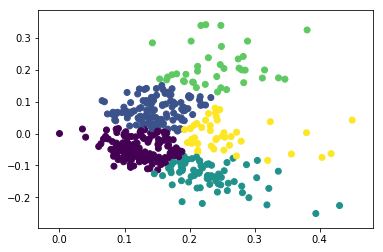

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0         36      48       28      35       1
1          0       4        0      48      72
2         27      40        2       6       0
3          0       0        0       0      39
4          1       8        0      29       4


In [24]:
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_tfidf)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

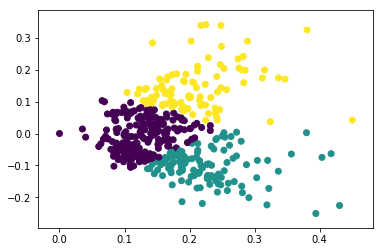

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0         32      38       24      84      34
1         32      59        6      23       1
2          0       3        0      11      81


In [25]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

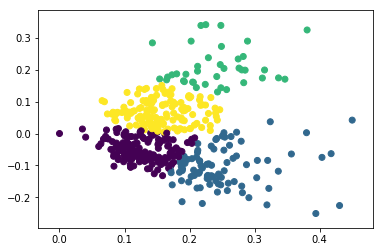

Comparing k-means clusters against the data:
topic  books  cinema  cooking  gaming  sports
row_0                                        
0         37      52       28      34       1
1         27      40        2      22       1
2          0       0        0       0      39
3          0       8        0      62      75


In [26]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

# Topic Sentence
Find main sentence for each article, then a topic topic sentence for each topic?

In [27]:
parser = spacy.load('en')

parsed = []
for r in range(len(df)):
    try:
        parsed_text = parser(df['text'][r])
        parsed.append(parsed_text)
    except KeyError:
        pass  

In [28]:
df['parsed'] = parsed

In [29]:
def main_sent(text):    
    sentences=[]

    for span in text.sents:
            # go from the start to the end of each span, returning each token in the sentence
            # combine each token using join()
        sent = ''.join(text[i].string for i in range(span.start, span.end)).strip()
        sentences.append(sent)

        # Creating the tf-idf matrix.
    counter = TfidfVectorizer(lowercase=False, 
                              stop_words=None,
                              ngram_range=(1, 1), 
                              analyzer=u'word', 
                              max_df=.5, 
                              min_df=1,
                              max_features=None, 
                              vocabulary=None, 
                              binary=False)

        #Applying the vectorizer
    data_counts=counter.fit_transform(sentences)

    # Calculating similarity
    similarity = data_counts * data_counts.T

    # Identifying the sentence with the highest rank.
    nx_graph = nx.from_scipy_sparse_matrix(similarity)
    ranks=nx.pagerank(nx_graph, alpha=.85, tol=.00000001)

    ranked = sorted(((ranks[i],s) for i,s in enumerate(sentences)),
                    reverse=True)
    
    return(ranked[0][1])

In [30]:
main_sent(df['parsed'][1])

'The Lonely City, an exploration of loneliness based on her own and others’ experiences in New York City.'

In [31]:
df_mini = df.head(20)

In [32]:
main_sentences = []

for r in range(len(df_mini)):
    try:
        main_sent = main_sent(df_mini['parsed'][r])
        main_sentences.append(main_sent)
    except ValueError:
        pass
        


TypeError: 'str' object is not callable

# Keywords
What are the key words for each topic?

In [33]:
def keywords(text):
    # Removing stop words and punctuation, then getting a list of all unique words in the text
    text_filt = [word for word in text if word.is_stop==False and (word.pos_=='NOUN' or word.pos_=='ADJ')]
    words=set(text_filt)

    #Creating a grid indicating whether words are within 4 places of the target word
    adjacency=pd.DataFrame(columns=words,index=words,data=0)

    #Iterating through each word in the text and indicating which of the unique words are its neighbors
    for i,word in enumerate(text):
        # Checking if any of the word's next four neighbors are in the word list 
        if any([word == item for item in text_filt]):
            # Making sure to stop at the end of the string, even if there are less than four words left after the target.
            end=max(0,len(text)-(len(text)-(i+5)))
            # The potential neighbors.
            nextwords=text[i+1:end]
            # Filtering the neighbors to select only those in the word list
            inset=[x in text_filt for x in nextwords]
            neighbors=[nextwords[i] for i in range(len(nextwords)) if inset[i]]
            # Adding 1 to the adjacency matrix for neighbors of the target word
            if neighbors:
                adjacency.loc[word,neighbors]=adjacency.loc[word,neighbors]+1

    print('done!')
    
    # Running TextRank
    nx_words = nx.from_numpy_matrix(adjacency.as_matrix())
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

    # Identifying the five most highly ranked keywords
    ranked = sorted(((ranks[i],s) for i,s in enumerate(words)),
                    reverse=True)
    print(ranked[:5])

In [34]:
books = ' '.join(df[df['topic']=='books']['text'])
books = parser(books)

In [35]:
keywords(books)

done!
[(0.00019088158152087389, interests), (0.00018940362751230556, volumes), (0.00018919414331158596, world), (0.0001876679473457359, work), (0.0001876679473457359, brown)]


In [36]:
sports = ' '.join(df[df['topic']=='sports']['text'])
sports = parser(sports)

keywords(sports)

done!
[(0.0001533136904219879, relationship), (0.0001521266160668421, 2-guard), (0.0001521266160668421, offseason), (0.00015073253943664237, leader), (0.00015073253943664237, competition)]
